In [ ]:
! pip install pyspellchecker

In [ ]:
! python -m spacy download en_core_web_lg

In [ ]:
! pip install pyLDAvis

In [8]:
! pip install tomotopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.3 MB 8.3 MB/s 


In [56]:
# import the package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import re
import seaborn as sns
# import packages
from sklearn.linear_model import LogisticRegression
from spellchecker import SpellChecker
from collections import Counter, OrderedDict
from sklearn.model_selection import train_test_split
import en_core_web_lg
import spacy 
import pyLDAvis
from tracemalloc import stop
from langcodes import best_match
from matplotlib import rc
import tomotopy as tp
from gensim.models import Phrases


In [2]:
# load the data
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
# df_submission = pd.read_csv('./submission_file.csv')

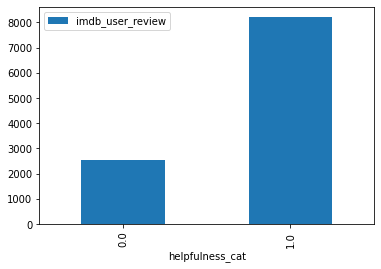

In [11]:
# check the distribution of the dataset by category
df_train.groupby('helpfulness_cat').count().plot.bar(ylim=0)
plt.show()

In [12]:
df_test.head()

,_id,imdb_user_review
0,610d01fe9a63eb113d2235ac,This is basically a German takeoff on a Sherlo...
1,610d01fe9a63eb113d224536,"In January of 1924, director Erich von Strohei..."
2,610d01fe9a63eb113d224d14,Silent movies are not for everyone. Neither ar...
3,610d01fe9a63eb113d225f17,It so often happens that some films take the l...
4,610d01fe9a63eb113d225f1a,I saw this film for the very first time last w...


In [3]:
nlp = spacy.load("en_core_web_lg")

In [4]:
# separate x and y
review_text = df_train['imdb_user_review']
review_cat = df_train['helpfulness_cat']

### Preprocessing text

In [15]:
# define a data cleaning function
def clean_data(reviews):
    # # step 1: separate x and y
    # convert review_text df to list
    reviews = reviews.to_list()
    
    # step 2: nromalize the review
    print(f"Total voc number: {len(reviews)}")
    reviews = list(map(lambda x: x.lower(),reviews))

    # step 3: remove Unicode Characters (punctuation, emoji,rul and @) 
    reviews = list(map(lambda x: re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", x),reviews))

    # step 4: remove whitespaces and trailing spaces
    def remove_whitespace(text):
        pattern = re.compile(r'\s+') 
        Without_whitespace = re.sub(pattern, ' ', text)
        text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
        text = text.strip()
        return text
    reviews=list(map(lambda x: remove_whitespace(x),reviews))
                                                                                                                                                                                                                                                                                                    
    # step 5: apply nlp pipeline remove stop words, numbers and lematize the words
    
    # expand the list of stopwords
    gist_file = open("gist_stopwords.txt", "r")
    try:
        content = gist_file.read()
        stopwords = content.split(",")
    finally:
        gist_file.close()
      
    stopwords=[i.replace('"',"").strip() for i in stopwords]
    # add the stopwords to the list of stopwords
    for i in stopwords:
      nlp.Defaults.stop_words.add(i)

    # create colloum for cleaned reviews
    reviews_tokens, tmp_tokens = [], [] 
    for review in tqdm.tqdm(reviews):
        tmp_tokens = [
            token.lemma_
            for token in nlp(review)
            if not token.is_stop 
            and not token.like_num
            and not token.is_punct
            and token.is_alpha
            ]
        reviews_tokens.append(tmp_tokens)
        tmp_tokens=[]
        
    # # convert list back to df 
    # reviews = pd.DataFrame({'imbd_user_review':reviews_tokens})

    return reviews_tokens

In [ ]:
train = clean_data(review_text)

Total voc number: 10755


 11%|█▏        | 1225/10755 [00:58<04:58, 31.98it/s]

In [ ]:
# create a dataframe for analysis
reviews = pd.DataFrame({'imbd_user_review':train,'helpfulness_cat':review_cat})

In [ ]:
# build spell checker and create spell mistakes
spell = SpellChecker()
mdy_train, temp_train = [], []
for comment in tqdm.tqdm(train):
    temp_train = [word if word in spell else spell.correction(word) for word in comment]
    mdy_train.append(temp_train)
    temp_train=[]
# spell.word_frequency.remove('aka')

In [ ]:
import pickle
file_name='correct_train2.txt'
with open(file_name, "wb") as fp:   #Pickling
    pickle.dump(mdy_train, fp)

In [5]:
import pickle
with open('correct_train2.txt','rb') as fp:
  mdy_train = pickle.load(fp)

In [9]:
# remove bracket within the list
tokens_list = [", ".join(token) for token in mdy_train]

## Feature Enginerring

In [ ]:
# import contextualSpellCheck
# contextualSpellCheck.add_to_pipe(nlp)
# text= ['creaaaation']
# doc = nlp(text)
# print(doc._.performed_spellCheck) #Should be True
# print(doc._.outcome_spellCheck) #Income was $9.4 million compared to the prior year of $2.7 million.

### Topic Modeling

In [ ]:
# get rid of common terms
common_terms = [
    u"of",
    u"with",
    u"without",
    u"and",
    u"or",
    u"the",
    u"a",
    u"not",
    "be",
    u"to",
    u"this",
    u"who",
    u"in",
]
## find phrases
# find bigram first
bigram = Phrases(
    mdy_train,
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
# find trigram
trigram = Phrases(
    bigram[mdy_train],
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
# uncomment if bi-grammed, tokenized document is preferred
# docs_phrased = [bigram[line] for line in docs_tokens]
docs_phrased = [trigram[bigram[line]] for line in mdy_train]

In [ ]:
# create a corpus using Tomotopy utils
# empty corpus
corpus = tp.utils.Corpus()
# populate the corpus
for item in docs_phrased:
    corpus.add_doc(words=item)


# topic modeling ― explore model validity
# register "UMass" coherence scores
cvs = {}
for topic_number in tqdm.tqdm(range(1, 100, 1)):
    mdl = tp.LDAModel(k=topic_number, corpus=corpus)
    for i in range(0, 100, 10):
        mdl.train(10)
        print("Iteration: {}\tLog-likelihood: {}".format(i, mdl.ll_per_word))
    coh = tp.coherence.Coherence(mdl, coherence="u_mass")
    cvs[topic_number] = coh.get_score()

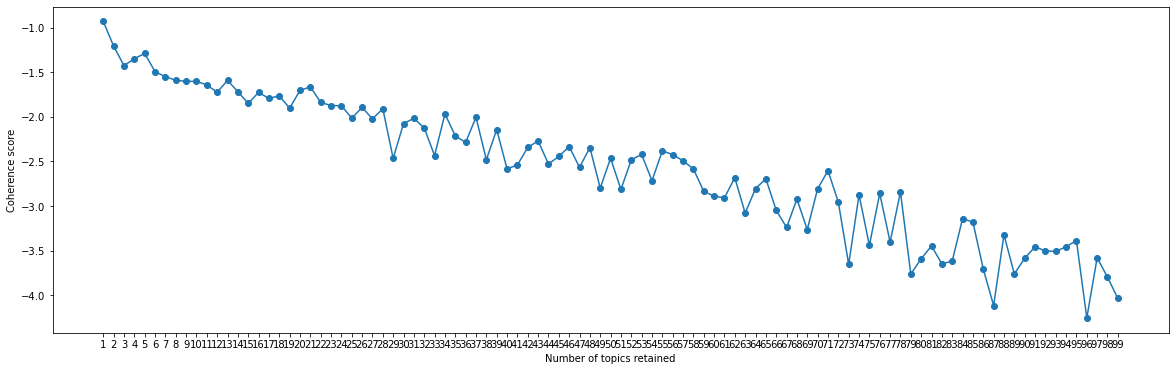

In [ ]:
# plot coherence scores
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)
ax.plot(cvs.keys(), cvs.values(), "o-")
ax.set_xlabel("Number of topics retained")
ax.set_ylabel("Coherence score")
ax.set_xticks(range(1, 100, 1))
plt.show()

In [ ]:
# topic model estimation
best_mdl = tp.LDAModel(k=6, corpus=corpus)
for i in range(0, 100, 10):
    best_mdl.train(10)
    print("Iteration: {}\tLog-likelihood: {}".format(i, best_mdl.ll_per_word))

Iteration: 0	Log-likelihood: -9.376981115855138
Iteration: 10	Log-likelihood: -9.165132967083652
Iteration: 20	Log-likelihood: -9.018529955486898
Iteration: 30	Log-likelihood: -8.93299417218789
Iteration: 40	Log-likelihood: -8.880746374344088
Iteration: 50	Log-likelihood: -8.844001457007263
Iteration: 60	Log-likelihood: -8.822804994211245
Iteration: 70	Log-likelihood: -8.805778555140419
Iteration: 80	Log-likelihood: -8.79411948533754
Iteration: 90	Log-likelihood: -8.780885049800284


In [ ]:
best_mdl.summary()

<Basic Info>
| LDAModel (current version: 0.12.2)
| 10755 docs, 845956 words
| Total Vocabs: 45017, Used Vocabs: 45017
| Entropy of words: 8.10067
| Entropy of term-weighted words: 8.10067
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 100, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -8.78089
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 6 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 3625314421 (random seed)
| trained in version 0.12.2
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [1.96483

In [ ]:
# prepare data for visualization
topic_term_dists = np.stack([best_mdl.get_topic_word_dist(k) for k in range(best_mdl.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in best_mdl.docs])
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
doc_lengths = np.array([len(doc.words) for doc in best_mdl.docs])
vocab = list(best_mdl.used_vocabs)
term_frequency = best_mdl.used_vocab_freq

# visualize the topics
prepared_data = pyLDAvis.prepare(
    topic_term_dists, 
    doc_topic_dists, 
    doc_lengths, 
    vocab, 
    term_frequency,
    start_index=0, # tomotopy starts topic ids with 0, pyLDAvis with 1
    sort_topics=False # IMPORTANT: otherwise the topic_ids between pyLDAvis and tomotopy are not matching!
)
pyLDAvis.save_html(prepared_data, 'ldavis.html')

/Users/sunsiyuan/opt/anaconda3/envs/smm750_Dig_tech_Value_cre/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/sunsiyuan/opt/anaconda3/envs/smm750_Dig_tech_Value_cre/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/sunsiyuan/opt/anaconda3/envs/smm750_Dig_tech_Value_cre/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/sunsiyuan/opt/anaconda3/envs/smm750_Dig_tech_Value_cre/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in 

In [ ]:
pyLDAvis.enable_notebook()
DATA_VIS = pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab,term_frequency)


In [ ]:
# word to topic probabilities
# an empty Pandas DF to populate
wt = pd.DataFrame()
# get word probabilities for each topic
for k in range(best_mdl.k):
    words, probs = [], []
    for word, prob in best_mdl.get_topic_words(k):
        words.append(word)
        probs.append(prob)
    tmp = pd.DataFrame(
        {
            "word": words,
            "prob": np.round(probs, 3),
            "k": np.repeat(k, len(words)),
            "sort": np.arange(0, len(words)),
        }
    )
    wt = pd.concat([wt, tmp], ignore_index=False)
    del tmp


# get topic probabilities for each document
td = pd.DataFrame(
    np.stack([doc.get_topic_dist() for doc in best_mdl.docs]),
    columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
)

### BOW

### Word Embedding

### TF-IDF & Ngrams

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
def simple_logistic_classify(x_train, x_test,y_train, y_test):
    model = LogisticRegression(C=1.0).fit(x_train, y_train)
    score = model.score(x_test, y_test)
    return score


In [95]:
# explore word frequencies
word_freq = Counter(x for xs in mdy_train for x in set(xs)).most_common()
word_fr = pd.DataFrame(word_freq, columns=['word', 'freq']).sort_values(by='freq', ascending=False)
word_fr




,word,freq
0,watch,3589
1,story,3401
2,time,3383
3,good,3127
4,character,2872
...,...,...
28827,antarcticwhat,1
28826,tugging,1
28825,glaciercovered,1
28824,edifice,1


In [67]:
word_fr.loc[0:2600]

,word,freq
0,movie,7217
1,film,5295
2,watch,3589
3,story,3401
4,time,3383
...,...,...
2606,stanley,35
2603,concert,35
2602,amateurish,35
2601,characterization,35


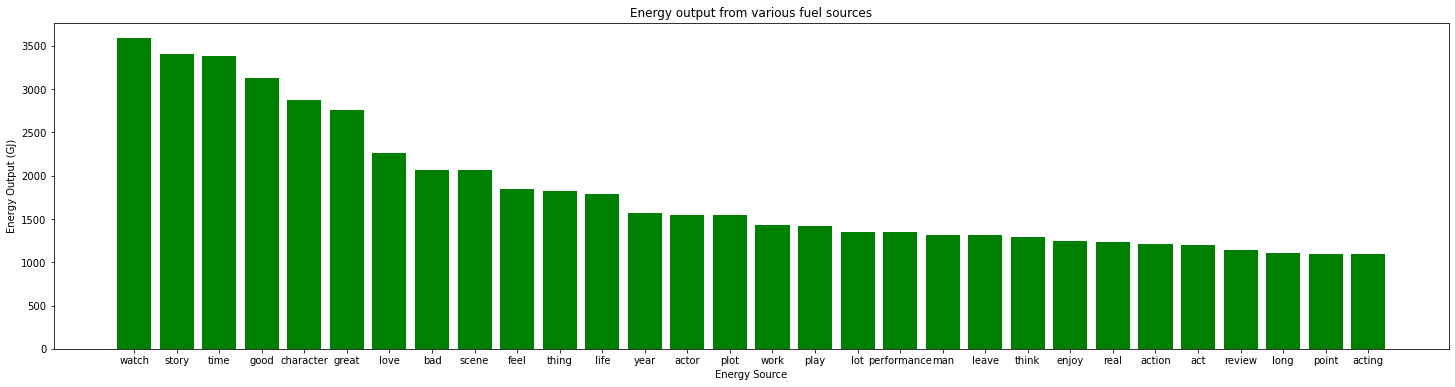

In [113]:
# visualize word frequencies
# figure size
fig = plt.figure(figsize=(25, 6))
plt.bar(word_fr.word[0:30], word_fr.freq[0:30], color='green')
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Word Frequency")
plt.show()



In [114]:
# remove most frequent words which is known in this context
wordsd = ['movie','film','people','time','man','lot']
final, tmp=[],[]
tt = mdy_train.copy()
for review in tt:
    # iterating on a copy since removing will mess things up
    for word in review:
        if word != 'movie' or word !=  'film' or word !=  'people':
            tmp.append(word)
    final.append(tmp)
    tmp=[]

In [155]:
mdy_train[1149]

['sound',
 'stupid',
 'animate',
 'favorite',
 'animate',
 'disney',
 'animated',
 'time',
 'animation',
 'beautiful',
 'story',
 'powerful',
 'move',
 'character',
 'terrific',
 'villain',
 'disney',
 'monstrous',
 'song',
 'incredible',
 'favorite',
 'animated',
 'favorite',
 'soundtrack',
 'strong',
 'power',
 'elton',
 'john',
 'lion',
 'king',
 'absolutely',
 'beautiful',
 'pleasure',
 'watch',
 'day',
 'story',
 'beautiful',
 'bring',
 'tear',
 'eye',
 'year',
 'beg',
 'dad',
 'prerelease',
 'lion',
 'king',
 'adult',
 'parent',
 'child',
 'simba',
 'father',
 'die',
 'start',
 'ball',
 'dad',
 'prissy',
 'saaaaad',
 'simba',
 'daddy',
 'sap',
 'powerful',
 'pride',
 'land',
 'raki',
 'wise',
 'monkey',
 'anoint',
 'simba',
 'newborn',
 'cub',
 'king',
 'mucosa',
 'queen',
 'arab',
 'present',
 'gathering',
 'animal',
 'pride',
 'rock',
 'advantage',
 'cub',
 'naive',
 'nature',
 'simba',
 'scheming',
 'uncle',
 'scar',
 'angry',
 'simba',
 'birth',
 'long',
 'throne',
 'tell',
 

In [116]:
# remove bracket within the list
tokens_list = [", ".join(token) for token in final]

In [122]:
# select n-gram
# train model with different n-gram ranges
for N in tqdm.tqdm(range(1,5)):
    vectorizer = TfidfVectorizer(ngram_range=(1,N), max_features=2600)#TODO make a loop to find out the best value2600
    tfidf_output = vectorizer.fit_transform(tokens_list)
    x = vectorizer.get_feature_names_out()
    # contact the result of tfidf and index
    df_tfidfvect = pd.DataFrame(data = tfidf_output.toarray(),columns = x)

    # train model and generate predictions
    # split indepedent variable train and validation set
    x_train, x_test = train_test_split(df_tfidfvect, test_size=0.3, random_state=42)
    # split dependent varaible 
    y_train, y_test = train_test_split(review_cat, test_size=0.3, random_state=42)

    # compute f-1 score
    model = simple_logistic_classify(x_train, x_test,y_train, y_test)
    print('F-1 score of model with n-gram range of {}: {}'.format((1,N),model))



 25%|██▌       | 1/4 [00:03<00:10,  3.62s/it]

F-1 score of model with n-gram range of (1, 1): 0.7923768205763867


 50%|█████     | 2/4 [00:08<00:08,  4.25s/it]

F-1 score of model with n-gram range of (1, 2): 0.7914471645491168


 75%|███████▌  | 3/4 [00:17<00:06,  6.54s/it]

F-1 score of model with n-gram range of (1, 3): 0.7914471645491168


100%|██████████| 4/4 [00:30<00:00,  7.73s/it]

F-1 score of model with n-gram range of (1, 4): 0.7914471645491168


In [126]:
# final n-gram is 1-gram
vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=2600)#
tfidf_output = vectorizer.fit_transform(tokens_list)
x = vectorizer.get_feature_names_out()
# contact the result of tfidf and index
df_tfidfvect = pd.DataFrame(data = tfidf_output.toarray(),columns = x)

### Length Analysis 

In [123]:
df_mdy_train = pd.DataFrame({'imbd_user_review':mdy_train})

In [124]:
df_mdy_train['word_count'] = df_mdy_train["imbd_user_review"].apply(lambda x: len(x))
df_mdy_train['char_count'] = df_mdy_train["imbd_user_review"].apply(lambda x: sum(len(word) for word in x))
# reviews['sentence_count'] = reviews["imbd_user_review"].apply(lambda x: len(str(x).split(".")))
df_mdy_train['avg_word_length'] = df_mdy_train['char_count'] / df_mdy_train['word_count']
# reviews['avg_sentence_lenght'] = reviews['word_count'] / reviews['sentence_count']
df_mdy_train.head()

,imbd_user_review,word_count,char_count,avg_word_length
0,"[hard, delightful, adorable, day, kid, silent,...",43,280,6.511628
1,"[fade, haunt, masterpiece, silent, cinema, any...",135,837,6.200000
2,"[view, age, yrsprobably, think, terrific, view...",14,93,6.642857
3,"[doubt, resemble, complete, version, metropoli...",63,446,7.079365
4,"[shocked, rivet, doubt, scifi, explain, positi...",35,220,6.285714


NameError: name 'reviews' is not defined

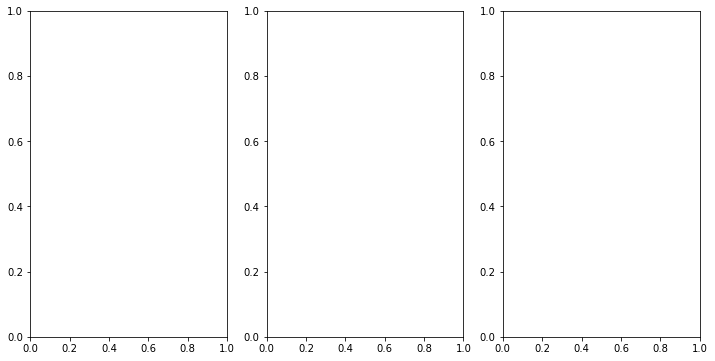

In [125]:
# visualize the distribution of the dataset
import seaborn as sns
x1,x2,x3,y = "word_count","char_count","avg_word_length", "helpfulness_cat"
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(12,6))
for i in reviews[y].unique():
    sns.distplot(reviews[reviews[y]==i][x1], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(reviews[reviews[y]==i][x2], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[1])
    sns.distplot(reviews[reviews[y]==i][x3], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[2])
ax[0].grid(True)
ax[0].legend(reviews[y].unique())
ax[0].set_title("word_count")
ax[1].grid(True)
ax[1].legend(reviews[y].unique())
ax[1].set_title("char_count")
ax[2].grid(True)
ax[2].legend(reviews[y].unique())
ax[2].set_title("avg_word_length")
plt.show()

### Dimension Reduction

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# Use TSNE to reduce the demension to 2
TSNE_model = TSNE(n_components=3, random_state=0)
TSNE_result = TSNE_model.fit_transform(df_tfidfvect)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
TSNE_result_dfm = pd.DataFrame(TSNE_result, columns=['x', 'y','z'])
TSNE_result_dfm.head()

,x,y,z
0,35.296894,33.511894,-18.957975
1,43.665710,28.387058,6.490153
2,-3.823193,5.475380,-1.629816
3,20.880701,10.970266,-16.563936
4,27.041716,7.643130,-22.914478


### Combine features

In [135]:
from sklearn.preprocessing import MinMaxScaler

In [136]:
scaler = MinMaxScaler()

In [143]:
df3.iloc[:,2600:2603] = scaler.fit_transform(df3.iloc[:,2600:2603])

In [127]:
df3 = pd.concat([df_tfidfvect, df_mdy_train.iloc[:,1:4]],axis="columns")

In [144]:
df3.head()

,abandon,ability,abrams,absolute,absolutely,absurd,abuse,academy,accent,accept,...,yesterday,york,young,youth,youtube,zombie,zone,word_count,char_count,avg_word_length
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034426,0.038186,0.309850
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109836,0.114971,0.282353
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010656,0.012407,0.321429
3,0.0,0.0,0.0,0.0,0.0,0.0,0.321394,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050820,0.061070,0.359944
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027869,0.029915,0.289916


### Logistic Regression

In [150]:
# split indepedent variable train and validation set
x_train, x_test = train_test_split(df_tfidfvect, test_size=0.3, random_state=42)

In [151]:
# split dependent varaible 
y_train, y_test = train_test_split(review_cat, test_size=0.3, random_state=42)

In [158]:
def simple_logistic_classify(x_train, y_train, x_test, y_test, _C=1):
    model = LogisticRegression(C=_C).fit(x_train, y_train)
    score = model.score(x_test, y_test)
    print('Test Score is', score)
    return model

In [159]:
model = simple_logistic_classify(x_train, y_train, x_test, y_test)

Test Score is 0.7709947319491788


In [ ]:
# hype-parameter tuning 
from sklearn.model_selection import GridSearchCV
import sklearn
param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}
# bow_search = sklearn.model_selection.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)
tfidf_search = sklearn.model_selection.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)

In [154]:
# confusion matrix and classification report(precision, recall, F1-score)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(classification_report(y_test, model.predict(x_test)))
print(confusion_matrix(y_test, model.predict(x_test)))

              precision    recall  f1-score   support

         0.0       0.66      0.19      0.30       740
         1.0       0.80      0.97      0.88      2487

    accuracy                           0.79      3227
   macro avg       0.73      0.58      0.59      3227
weighted avg       0.77      0.79      0.75      3227

[[ 144  596]
 [  74 2413]]


### Pytorch

In [ ]:
# %%
# load the data

# use one of the toy datasets coming with PyTorch
from torchdata.datapipes.iter import IterableWrapper, FileOpener
import os
def get_name(path_and_stream):
     return os.path.basename(path_and_stream[0]), path_and_stream[1]
 datapipe1 = IterableWrapper(["1.csv", "empty.csv", "empty2.csv"])
 datapipe2 = FileOpener(datapipe1, mode="b")
 datapipe3 = datapipe2.map(get_name)
 csv_parser_dp = datapipe3.parse_csv()
 list(csv_parser_dp)
[['key', 'item'], ['a', '1'], ['b', '2'], []]


# iterator for training data
train_iter = iter(YelpReviewPolarity(split='train'))

# %% 
# inspect the data

# exploit iter
next(train_iter)

# %% 
# buold the vocabulary

# load libraries
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
# tokenization
tokenizer = get_tokenizer('basic_english')
train_iter = YelpReviewPolarity(split='train')
# apply the tokenizer
# --+ custom function
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)
# --+ deploy the tokenizer to get the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# %%
# pre-processing pipelines

# tokenize Yelp reviews 
text_pipeline = lambda x: vocab(tokenizer(x))
# encode review labels
label_pipeline = lambda x: int(x) - 1

# %%
# data batches

# load libraries
import torch
from torch.utils.data import DataLoader
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# custom function
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)
# deploy the function
train_iter = YelpReviewPolarity(split='train')
dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)

# %%
# model creation

# load libraries
from torch import nn
# the class associated with the module
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)
    
# %%
# model set up

# examples
train_iter = YelpReviewPolarity(split='train')
# classes
num_class = len(set([label for (label, text) in train_iter]))
# vocabulary size
vocab_size = len(vocab)
# ebedding bag size
emsize = 64
# model instantiation
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

# %%
# model training and evaluation

# load library 
import time
# custom function for training 
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

# custom function for evaluation
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

# %%
# training - validation split and model run

# load libraries 
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
# hyperparameters for the search
# --+ epoch
EPOCHS = 10 
# --+ learning rate
LR = 5  
# --+ batch size for training
BATCH_SIZE = 64 
# optimization
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
# data handling
train_iter, test_iter = YelpReviewPolarity()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)
# logging
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)


# %%
# model evaluation

print('Checking the results of test dataset.')
accu_test = evaluate(test_dataloader)
print('test accuracy {:8.3f}'.format(accu_test))

# %%
# test on random unseen review

# labels
review_label = {1: "BAD",
                2: "GOOD"}

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1

ex_text_str = "."

model = model.to("cpu")

print("This is a %s Yelp reviews" %review_label[predict(ex_text_str, text_pipeline)])